# The 21 Charts of 2021 - Part 2

In this second part of the series, we'll focus on the charts related to the fintech space in Mexico.

To start let's make the basic imports so we can easily work with TUKAN's API and our `matplotlib` stylesheet.

In [95]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests

# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

## Chart 1: Konfío vs. Corporate Loans to SMEs

For this first chart we'll visualize the NPL ratios of Konfío's loan portfolio and compare it against the ratio recorded by the Mexican commercial banking system for loans issued to SMEs.

Let's go ahead and load the data that we'll be using in this particular viz. 

In [4]:
konfio_payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "institutions": [
            "237b57d15a5a398"
        ]
    },
    "request": [
        {
            "table": "mex_condusef_sofom_enr_loan_portfolio",
            "variables": [
                "05451c0b6d5ea78",
                "b4ea69bfe2b9735"
            ]
        }
    ],
    "from": "2017-01-01"
}

konfio_response = get_tukan_api_request(konfio_payload)

Success getting the data


In [5]:
konfio_data = konfio_response["data"].copy()

# We compute the NPL ratio
konfio_data.loc[:,"npl_ratio"] = konfio_data.loc[:,"b4ea69bfe2b9735"]/konfio_data.loc[:,"05451c0b6d5ea78"]
konfio_data.head()

,date,institutions__ref,institutions,05451c0b6d5ea78,b4ea69bfe2b9735,npl_ratio
0,2017-01-01,237b57d15a5a398,Konfío,34646454.0,6797884.0,0.196207
1,2017-04-01,237b57d15a5a398,Konfío,66212449.0,7419503.0,0.112056
2,2017-07-01,237b57d15a5a398,Konfío,104490797.0,8161436.0,0.078107
3,2017-10-01,237b57d15a5a398,Konfío,144944680.0,8549662.0,0.058986
4,2018-01-01,237b57d15a5a398,Konfío,215681193.0,16337791.0,0.075750


Now we query the SME loan portfolio for commercial banks, aggregated accross all instituions.

In [6]:
sme_payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "institutions": [
            "0c959ae6bc0d063"
        ],
        "company_size": [
            "428fd6823cfdd4f"
        ]
    },
    "request": [
        {
            "table": "mex_cnbv_cb_corp_loans",
            "variables": [
                "05451c0b6d5ea78",
                "b4ea69bfe2b9735"
            ]
        }
    ],
    "from": "2017-01-01"
}

sme_response = get_tukan_api_request(sme_payload)

Success getting the data


In [7]:
sme_data = sme_response["data"]

# We compute the NPL ratio
sme_data.loc[:,"npl_ratio"] = sme_data.loc[:,"b4ea69bfe2b9735"]/sme_data.loc[:,"05451c0b6d5ea78"]
sme_data.head()

,date,institutions__ref,institutions,company_size__ref,company_size,05451c0b6d5ea78,b4ea69bfe2b9735,npl_ratio
0,2017-01-01,0c959ae6bc0d063,Instituciones de banca múltiple,428fd6823cfdd4f,Pequeña y mediana (PyMe),4.334606e+11,1.815114e+10,0.041875
1,2017-02-01,0c959ae6bc0d063,Instituciones de banca múltiple,428fd6823cfdd4f,Pequeña y mediana (PyMe),4.374837e+11,1.837093e+10,0.041992
2,2017-03-01,0c959ae6bc0d063,Instituciones de banca múltiple,428fd6823cfdd4f,Pequeña y mediana (PyMe),4.447244e+11,1.854213e+10,0.041694
3,2017-04-01,0c959ae6bc0d063,Instituciones de banca múltiple,428fd6823cfdd4f,Pequeña y mediana (PyMe),4.452557e+11,1.868632e+10,0.041968
4,2017-05-01,0c959ae6bc0d063,Instituciones de banca múltiple,428fd6823cfdd4f,Pequeña y mediana (PyMe),4.466859e+11,1.935558e+10,0.043332


Notice that commercial banking data is presented on a monthly basis, whereas Konfío's data is presented on a quarterly basis. Therefore we have to make some adjustments to the commercial banking `dataframe` to make this information comparable.

For this we import the `datetime` function from the `datetime` module.

In [8]:
from datetime import datetime

In [9]:
# We add two months in order to join with commercial bank data.

konfio_data.loc[:, "date"] = [datetime(x.year, x.month + 2, x.day) for x in konfio_data["date"]]

chart_1_data = pd.merge(konfio_data, sme_data[["date", "npl_ratio"]], on = "date", how = "left")
chart_1_data.rename(columns = {"npl_ratio_x":"konfio_npl", "npl_ratio_y":"cb_npl"}, inplace = True)

chart_1_data.head()

,date,institutions__ref,institutions,05451c0b6d5ea78,b4ea69bfe2b9735,konfio_npl,cb_npl
0,2017-03-01,237b57d15a5a398,Konfío,34646454.0,6797884.0,0.196207,0.041694
1,2017-06-01,237b57d15a5a398,Konfío,66212449.0,7419503.0,0.112056,0.042250
2,2017-09-01,237b57d15a5a398,Konfío,104490797.0,8161436.0,0.078107,0.045621
3,2017-12-01,237b57d15a5a398,Konfío,144944680.0,8549662.0,0.058986,0.045269
4,2018-03-01,237b57d15a5a398,Konfío,215681193.0,16337791.0,0.075750,0.044728


Now that we have everything we need we can go ahead and work our visualization.

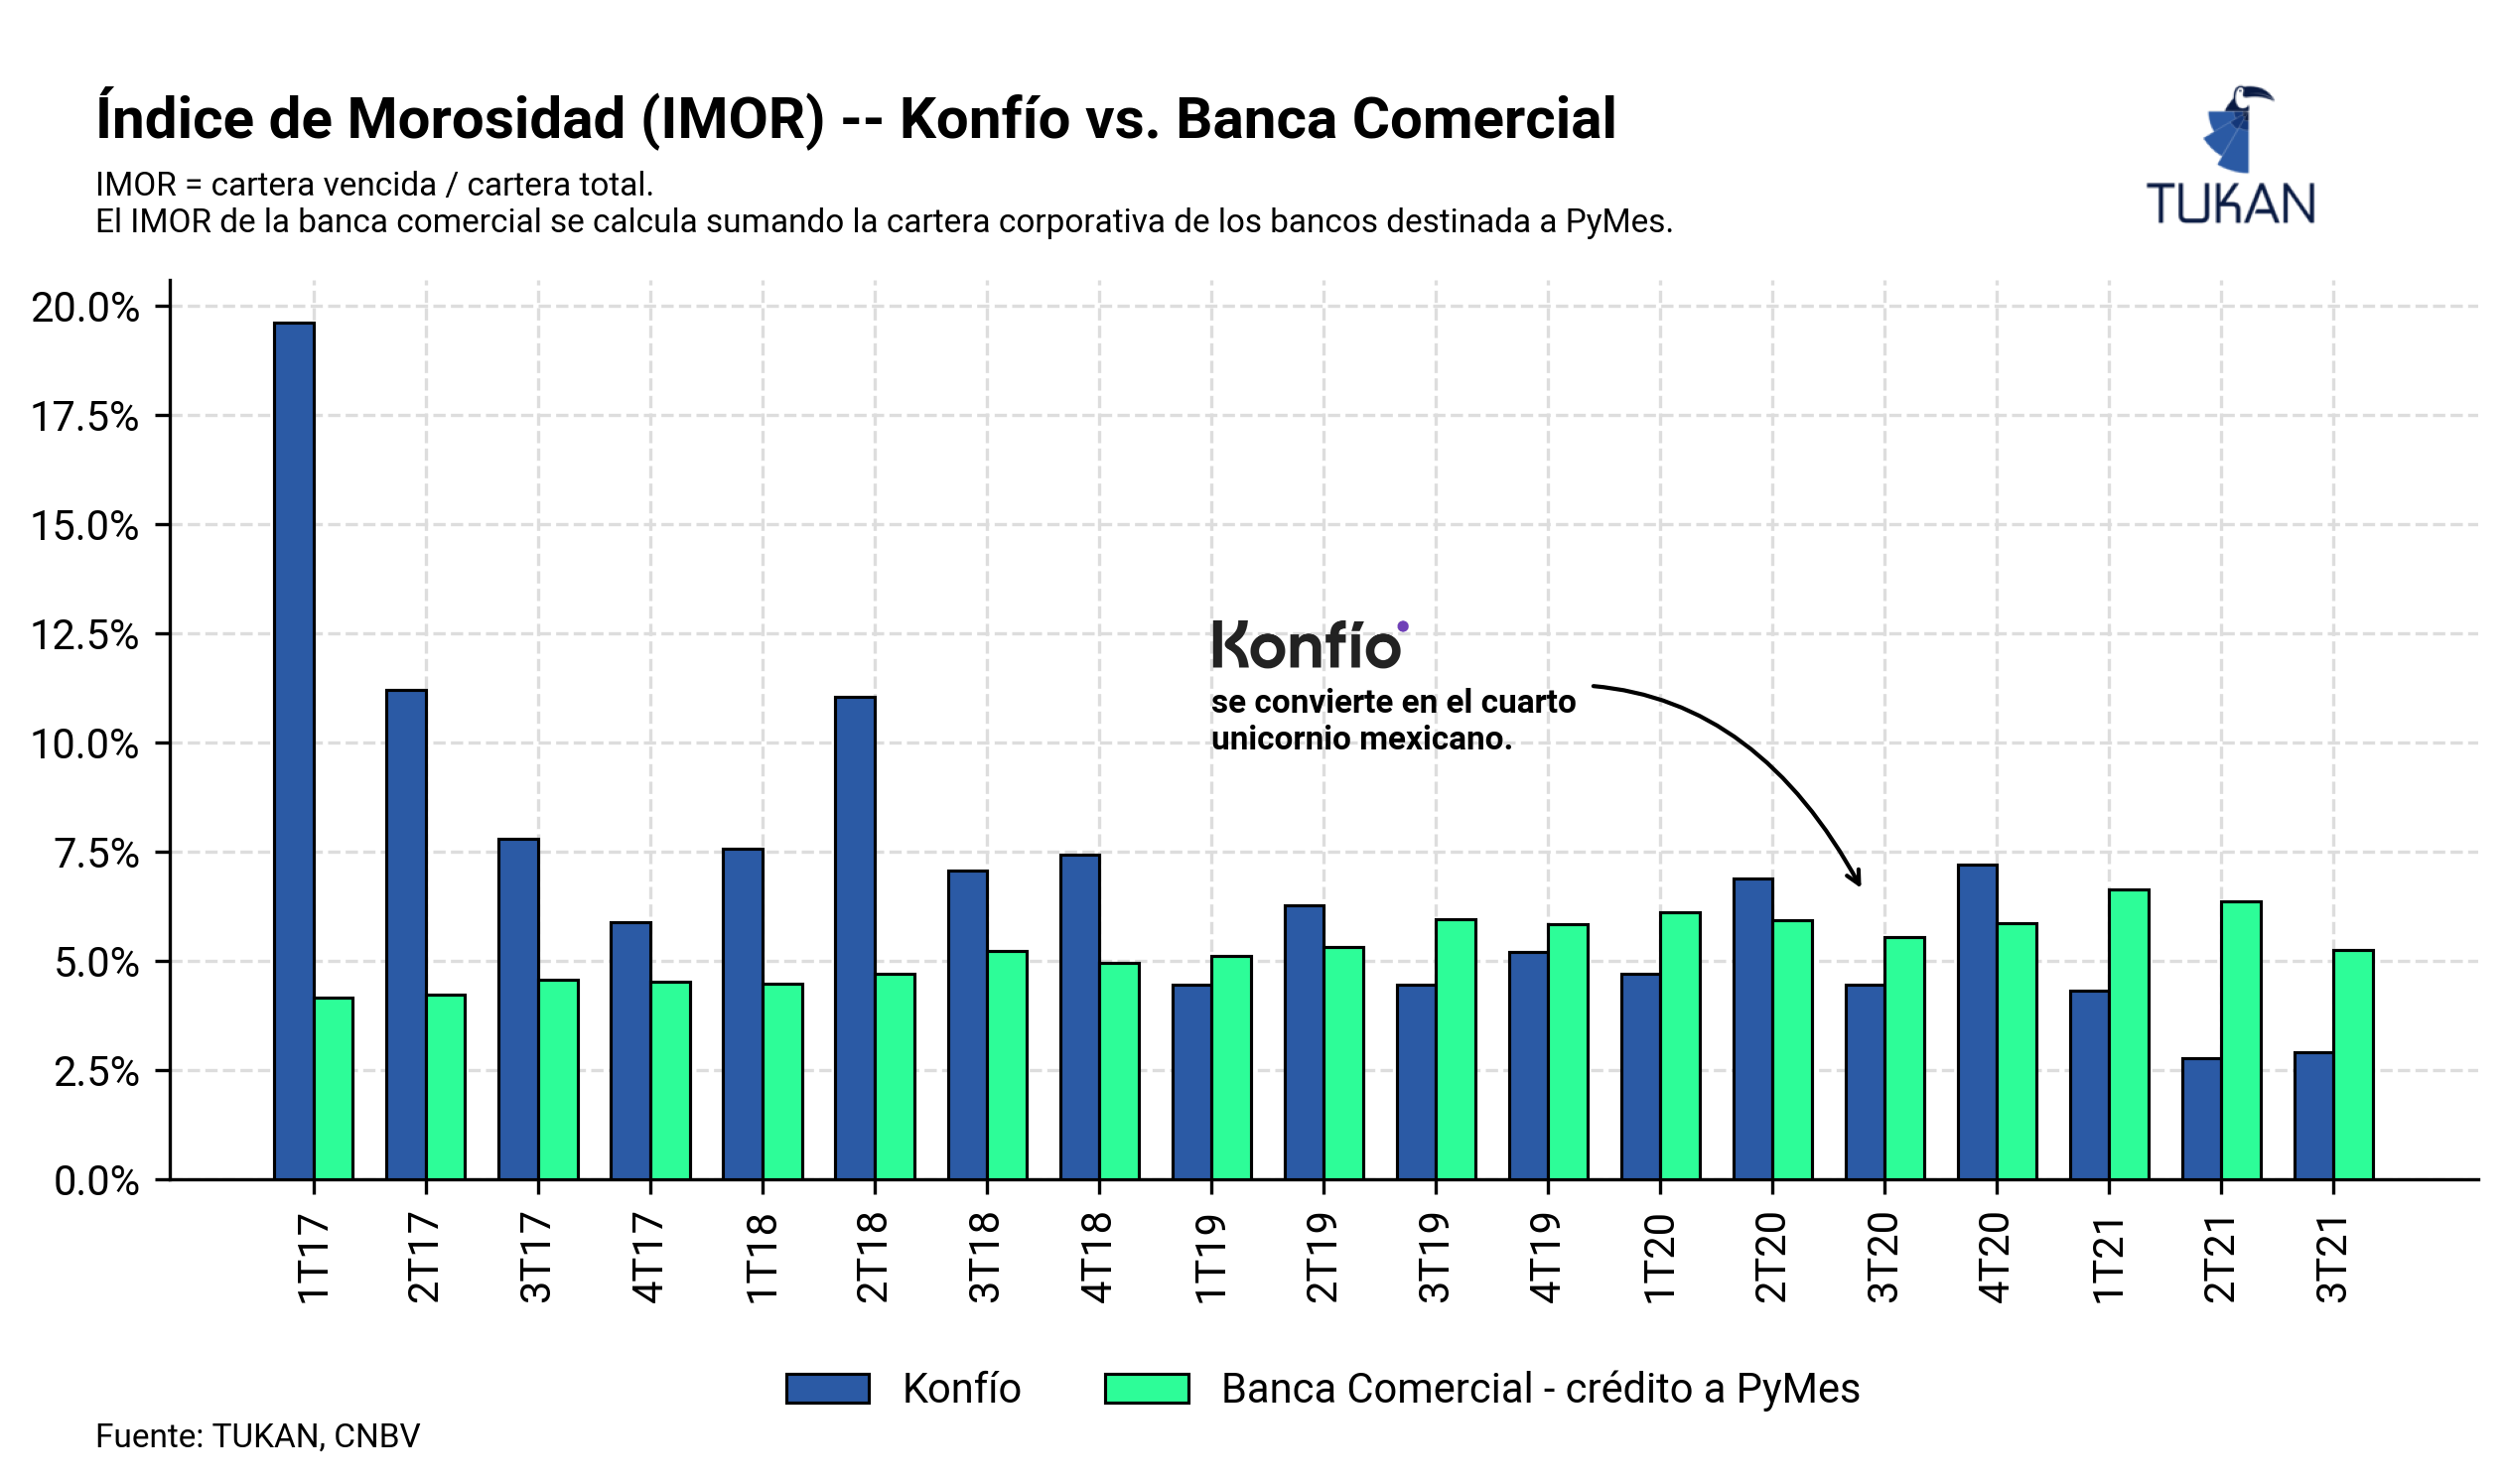

In [50]:
fig = plt.figure(figsize = (10, 4), dpi = 300)
ax = plt.subplot(111)

width = 0.35

ind = np.arange(chart_1_data.shape[0])

ax.bar(ind, chart_1_data["konfio_npl"], width = width, zorder = 3, edgecolor = "black", linewidth = 0.75, label = "Konfío")
ax.bar(ind + width, chart_1_data["cb_npl"], width = width, zorder = 3, edgecolor = "black", linewidth = 0.75, label = "Banca Comercial - crédito a PyMes")

# Add minor gridlines and format ticks
xticks = ax.xaxis.set_ticks(ind + width/2)
xticklabels = ax.xaxis.set_ticklabels([str(round(x.month/3)) + "T" + str(round(x.year - 2000,0)) for x in chart_1_data["date"]], rotation = 90)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.025))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1%}'))

# Add Konfio logo and annotations.
konfio_img = OffsetImage(image.imread("imgs//konfio_logo.png"), zoom = 0.12)
konfio_ab = AnnotationBbox(konfio_img, (9, .125), frameon=False, xycoords='data')
ax.add_artist(konfio_ab)

ax.annotate(
    "se convierte en el cuarto\nunicornio mexicano.",
    xy=(14,
        .065),
    xycoords="data",
    xytext=(-158, 42),
    textcoords="offset points",
    color="black",
    size=8,
    va="center",
    ha="left",
    weight="bold",
    arrowprops=dict(
        arrowstyle="->", ec="black", connectionstyle="arc3,rad=-.45"
    ),
)

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol = 2)

# Add title and subtitle
fig.text(
    0.1,
    1,
    "Índice de Morosidad (IMOR) -- Konfío vs. Banca Comercial",
    size=14,
    weight = "bold"
)

fig.text(
    0.1,
    0.92,
    "IMOR = cartera vencida / cartera total.\nEl IMOR de la banca comercial se calcula sumando la cartera corporativa de los bancos destinada a PyMes.",
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.1, -0.1, "Fuente: TUKAN, CNBV", fontsize=8)

plt.savefig(
    "plots/konfio_vs_banks_transparent_no_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.68, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/konfio_vs_banks_transparent_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/konfio_vs_banks_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

## Chart 2: Accounts in Brokerage Firms and Time Deposits

Retail investing has grown considerably in Mexico within the past few months. In this chart we aim to showcase how brokerage accounts have grown vs. growth in traditional banking time deposit accounts - which are banks highest interest generating savings product.

Let's start by querying the amount of time deposit accounts in Mexico since 2010. 

In [77]:
# This is a large dataset so we iterate over the payload.

dates_payload = pd.date_range(start = "2015-01-01", end = "2021-01-01", freq = "MS")

# Main payload
td_payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "institutions": [
            "0c959ae6bc0d063"
        ]
    },
    "request": [
        {
            "table": "mex_cnbv_cb_funding_data",
            "variables": [
                "447b148f977c326"
            ]
        }
    ]
}

td_data = pd.DataFrame()

# For loop where we concat the results
for index, x in enumerate(dates_payload):
    if dates_payload[-1] == x:
        td_payload.update({
            "from":dates_payload[index].strftime("%Y-%m-%d"),
            "to": None
            })
        response_aux = get_tukan_api_request(td_payload)
        data_aux = response_aux["data"]
        td_data = td_data.append(data_aux)
    elif index % 6 == 0:
        try:
            td_payload.update({
                "from":dates_payload[index].strftime("%Y-%m-%d"),
                "to":dates_payload[index + 5].strftime("%Y-%m-%d")
                })
            response_aux = get_tukan_api_request(td_payload)
            data_aux = response_aux["data"]
            td_data = td_data.append(data_aux)
        except Exception as e:
            print("Let's give the API some time to breathe.")
            time.sleep(10)
            td_payload.update({
                "from": dates_payload[index].strftime("%Y-%m-%d"),
                "to": dates_payload[index + 5].strftime("%Y-%m-%d")
                })
            response_aux = get_tukan_api_request(td_payload)
            data_aux = response_aux["data"]
            td_data = td_data.append(data_aux)
        print(dates_payload[index], dates_payload[index + 5])
    else:
        continue


Let's give the API some time to breathe.
Success getting the data
2015-01-01 00:00:00 2015-06-01 00:00:00
Success getting the data
2015-07-01 00:00:00 2015-12-01 00:00:00
Let's give the API some time to breathe.
Success getting the data
2016-01-01 00:00:00 2016-06-01 00:00:00
Success getting the data
2016-07-01 00:00:00 2016-12-01 00:00:00
Success getting the data
2017-01-01 00:00:00 2017-06-01 00:00:00
Success getting the data
2017-07-01 00:00:00 2017-12-01 00:00:00
Success getting the data
2018-01-01 00:00:00 2018-06-01 00:00:00
Success getting the data
2018-07-01 00:00:00 2018-12-01 00:00:00
Success getting the data
2019-01-01 00:00:00 2019-06-01 00:00:00
Success getting the data
2019-07-01 00:00:00 2019-12-01 00:00:00
Success getting the data
2020-01-01 00:00:00 2020-06-01 00:00:00
Success getting the data
2020-07-01 00:00:00 2020-12-01 00:00:00
Success getting the data


Cool. Now that we have collected the banking data, let's go ahead and query brokerage firm account numbers.

In [69]:
bf_payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "categories": {
        "institutions": [
            "8cd3fe0836098ba"
        ]
    },
    "request": [
        {
            "table": "mex_cnbv_bf_market_stats",
            "variables": [
                "6c05c234a0a1f8c"
            ]
        }
    ],
    "from": "2015-01-27"
}

bf_response = get_tukan_api_request(bf_payload)

Success getting the data


In [70]:
bf_data = bf_response["data"]
bf_data.head()

,date,institutions__ref,institutions,6c05c234a0a1f8c
0,2015-01-01,8cd3fe0836098ba,Casas de bolsa,218466.0
1,2015-02-01,8cd3fe0836098ba,Casas de bolsa,218858.0
2,2015-03-01,8cd3fe0836098ba,Casas de bolsa,219361.0
3,2015-04-01,8cd3fe0836098ba,Casas de bolsa,221186.0
4,2015-05-01,8cd3fe0836098ba,Casas de bolsa,221198.0


Since both datasets have a monthly frequency we can now merge the information on the `date` column.

In [92]:
account_data = pd.merge(bf_data, td_data, how = "inner", on = "date")

# Keep only quarters:
account_data = account_data[(account_data["date"].dt.month % 3 == 0)].copy()
# Transform data to millions
account_data.loc[:,"6c05c234a0a1f8c"] = account_data["6c05c234a0a1f8c"]/1000
account_data.loc[:,"447b148f977c326"] = account_data["447b148f977c326"]/1000

This one's easy to visualize because we are only looking for absolute numbers.

C:\Users\migue\AppData\Local\Temp/ipykernel_6372/122477033.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  xticklabels = ax.xaxis.set_ticklabels([str(round(x.month/3)) + "T" + str(round(x.year - 2000,0)) for x in account_data["date"] if (x.month == 9) or (x.month == 3)], rotation = 90)


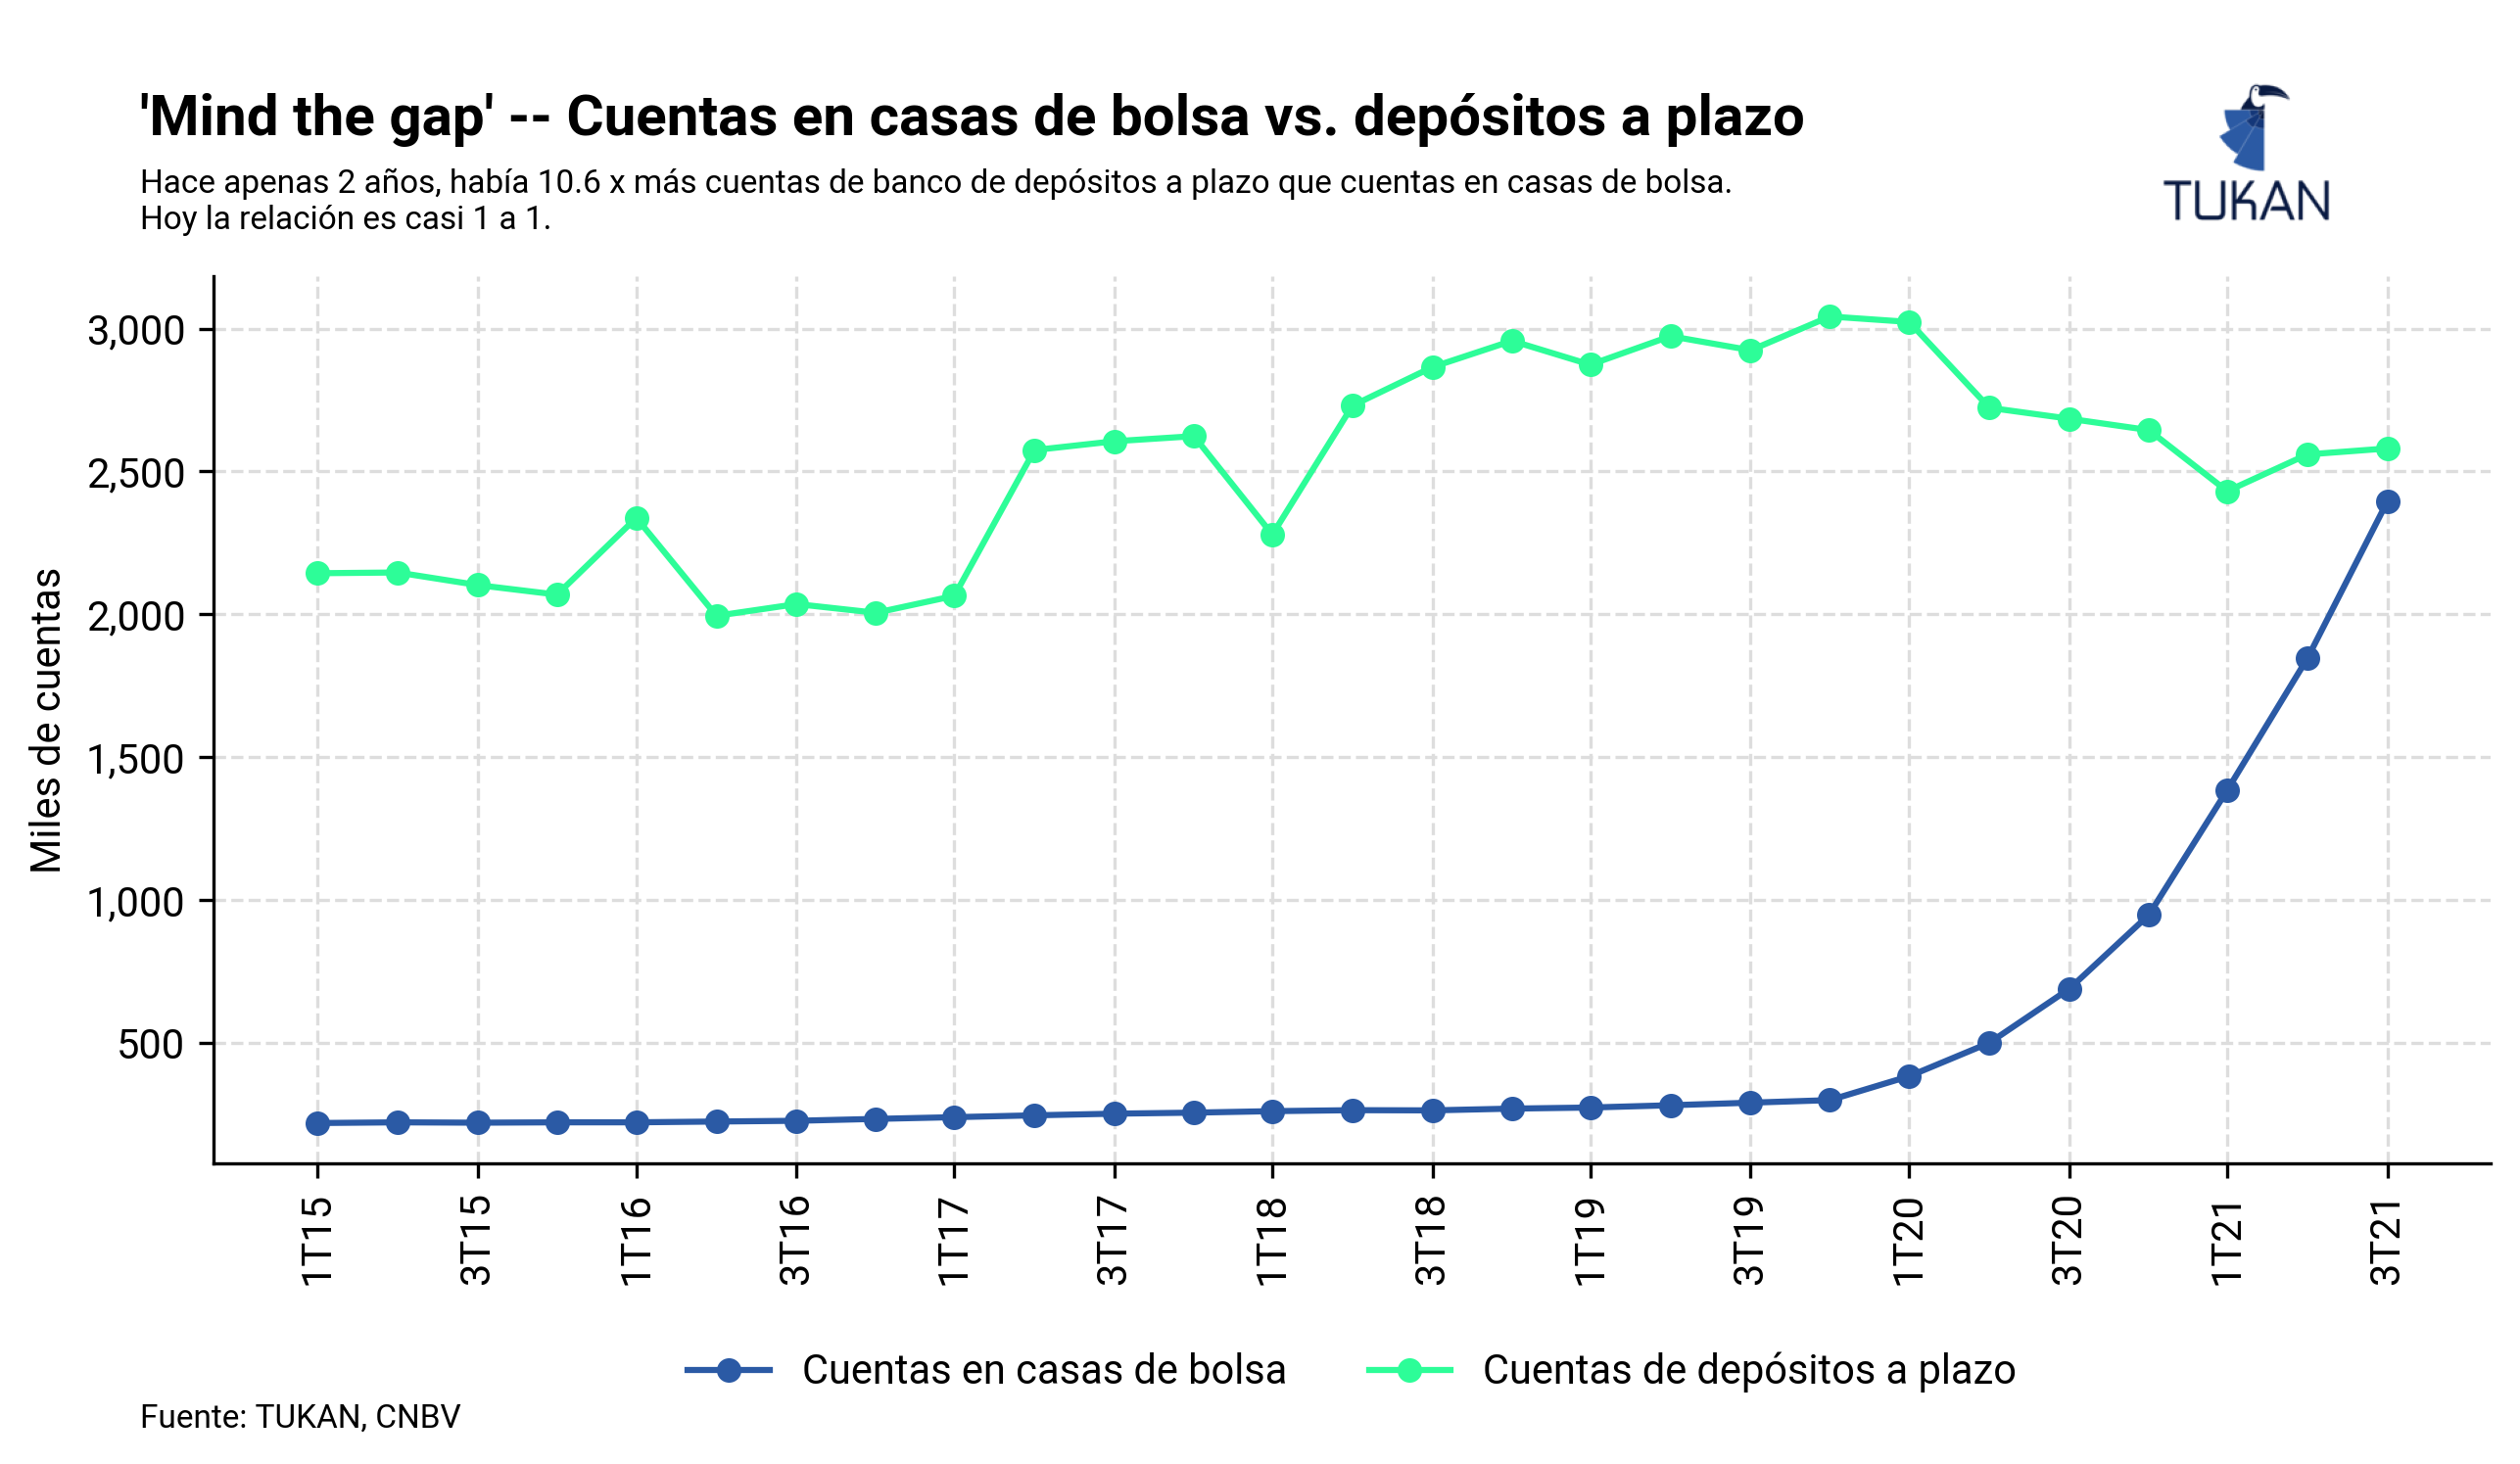

In [121]:
fig = plt.figure(figsize = (10, 4), dpi = 300)
ax = plt.subplot(111)

ax.plot(account_data["date"], account_data["6c05c234a0a1f8c"], marker = "o", label = "Cuentas en casas de bolsa", ms = 5)
ax.plot(account_data["date"], account_data["447b148f977c326"], marker = "o", label = "Cuentas de depósitos a plazo", ms = 5)


# Add minor gridlines and format ticks
xticks = ax.xaxis.set_major_locator(mdates.MonthLocator([3,9]))
xticklabels = ax.xaxis.set_ticklabels([str(round(x.month/3)) + "T" + str(round(x.year - 2000,0)) for x in account_data["date"] if (x.month == 9) or (x.month == 3)], rotation = 90)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol = 2)

# Add yaxis title

ax.yaxis.set_label_text("Miles de cuentas")

# Add title and subtitle
fig.text(
    0.1,
    1,
    "'Mind the gap' -- Cuentas en casas de bolsa vs. depósitos a plazo",
    size=14,
    weight = "bold"
)

fig.text(
    0.1,
    0.92,
    "Hace apenas 2 años, había 10.6 x más cuentas de banco de depósitos a plazo que cuentas en casas de bolsa.\nHoy la relación es casi 1 a 1.",
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.1, -0.1, "Fuente: TUKAN, CNBV", fontsize=8)


plt.savefig(
    "plots/brokers_vs_tdeposits_transparent_no_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.68, .88, 0.18, 0.21], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/brokers_vs_tdeposits_transparent_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/brokers_vs_tdeposits_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)